## Quick Analysis of COVID-19 confirmed cases data

I've been quite frustrated with the data showing raw cases.  I'm much more interested in how many cases there are compared with the total population of a country or region.  The following adjusts the latest confirmed cases data to adjust for the total population of the country or region.  All numbers are percentages, and as you can tell, they are quite small at the moment.  But it's helpful for comparisons.

Data was sourced from: https://github.com/CSSEGISandData/COVID-19

Last Updated: 2020-04-02

In [1]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dateparser
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
pop_filename='./general_data/world-pop.csv'
pop = pd.read_csv(pop_filename)
pop['region'] = pop['region'].fillna('')
pop['population'] = pop['population'].apply(float)
pop = pop.set_index(['country', 'region'])

In [3]:
filename='./output.csv'
df = pd.read_csv(filename, skiprows=0)
df = df.drop(columns=['Deaths', 'Recovered'])

df['region'] = df['region'].fillna('')
df = df.set_index(['country', 'region'])#, 'date'])
df['date'] = df['date'].apply(pd.to_datetime)
df = pd.merge(df, pop,  how='inner', left_on=['country', 'region'], right_on=['country', 'region'])
df['ratio'] = df['Confirmed']/df['population'] * 1000000.0
df = df.fillna(0)
df['Confirmed'] = df['Confirmed'].apply(int)
df = df.reset_index()
def by_country(df, names):
    df = df.loc[names]
    df = df.fillna(0)
    for d in df.columns:
        if d in ['country', 'population']:
            continue
        p = df['population'].apply(float)
        v = df[d]
        v = v.apply(float)
        v = v.divide(p)*100.0
        df[d] = v
    df = df.transpose()
    return df


# Latest Number of Confirmed Cases

In [4]:
areas_of_interest = [('US', 'Texas'), ('US', 'Utah'), ('Canada', 'British Columbia'), ('Canada','Ontario')]
pd.pivot_table(df, values='Confirmed', index=['date'],
                    columns=['country', 'region'], aggfunc=np.sum)[areas_of_interest].tail()

country         US                   Canada        
region       Texas    Utah British Columbia Ontario
date                                               
2020-03-29  2792.0   720.0            884.0  1355.0
2020-03-30  3147.0   804.0            970.0  1706.0
2020-03-31  3809.0   888.0           1013.0  1966.0
2020-04-01  4355.0   888.0           1013.0  2392.0
2020-04-02  5069.0  1092.0           1121.0  2793.0

# Canadian Provinces - Percentage of population confirmed

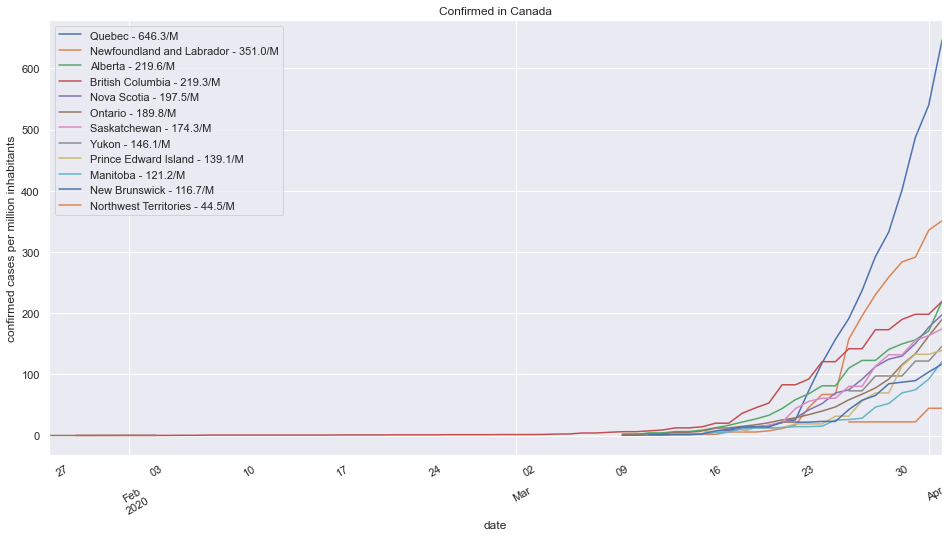

In [5]:
canada = df.loc[df['country'] == 'Canada']
canada = canada.drop(columns=['country'])

canada = canada.set_index(['date', 'region'])['ratio'].unstack(level=-1)
last_date = max(canada.index).date()
x = pd.DataFrame(canada.loc[last_date].fillna(0).sort_values(ascending=False))
canada = canada[x.index]

labels = list(map(lambda x: "%s - %.1f/M" % x, zip(x.index, x[x.columns[0]].to_list())))

ax = canada.plot(rot=30, figsize=(16,8), title='Confirmed in Canada')
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
ax.legend(labels)
pass

In [6]:
canada.tail()

region,Quebec,Newfoundland and Labrador,Alberta,British Columbia,Nova Scotia,Ontario,Saskatchewan,Yukon,Prince Edward Island,Manitoba,New Brunswick,Northwest Territories
date,,,,,,,,,,,,
2020-03-29,332.643294,258.935678,140.715943,172.963091,124.813675,92.102769,132.017000,97.375724,69.550702,52.267957,84.616144,22.269731
2020-03-30,401.748767,283.870225,149.779772,189.789817,129.928989,115.961124,132.017000,97.375724,113.810240,69.690610,87.180270,22.269731
2020-03-31,487.486404,291.542394,156.351048,198.203180,150.390247,133.633980,155.712359,121.719655,132.778614,74.772217,89.744395,22.269731
2020-04-01,540.076841,335.657361,170.853174,198.203180,176.989883,162.590275,163.328724,121.719655,132.778614,92.194869,103.847086,44.539462
2020-04-02,646.311864,351.001697,219.571254,219.334417,197.451141,189.847257,174.330141,146.063586,139.101405,121.232624,116.667714,44.539462


# US States - Percentage of population confirmed

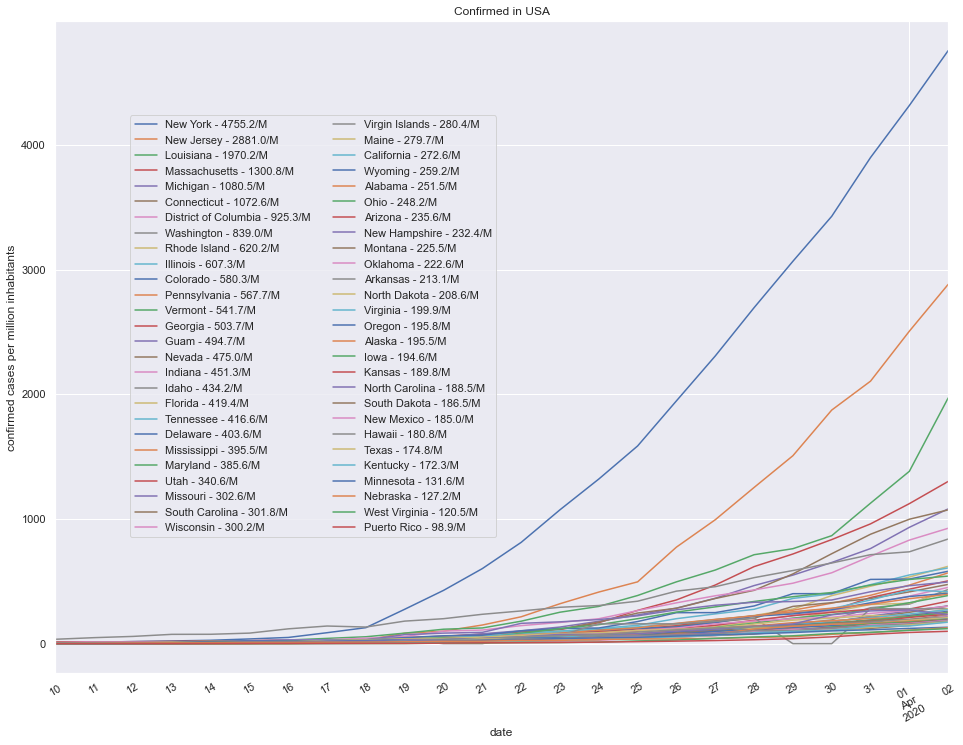

In [7]:
usa = df.loc[df['country'] == 'US'].loc[df['region'] != ''].groupby(by=['country', 'region', 'date']).sum()
last_date = str(max(usa.index.get_level_values(2)).date())
last_date
idx = pd.IndexSlice

x = usa.loc[idx[:,:,[last_date]], idx[['ratio', 'Confirmed', 'population']]].sort_values(by=['ratio'], ascending=False)
labels = list(map(lambda x: "%s - %.1f/M" % (x[0][1], x[1]), zip(x.index, x[x.columns[0]].to_list())))
rows = list(filter(lambda x: str(x[2]) > '2020-03-07', usa.index))
usa = usa.loc[rows]
usa = usa.reset_index()
usa = usa.drop(columns=['country'])

usa = pd.pivot_table(usa, values='ratio', index=['date'],
                     columns=['region'], aggfunc=np.sum).fillna(0)[x.index.get_level_values(1)]

ax = usa.plot(rot=30, figsize=(16,12), title='Confirmed in USA')
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
ax.legend(labels, bbox_to_anchor=(0.5, 0.2), ncol=2)
pass

# Percentage of Population Confirmed - Top 12 US States

In [8]:
x[:12][['Confirmed', 'ratio']]

Confirmed        ratio
country region               date                              
US      New York             2020-04-02      92506  4755.221936
        New Jersey           2020-04-02      25590  2881.046228
        Louisiana            2020-04-02       9159  1970.188397
        Massachusetts        2020-04-02       8966  1300.833674
        Michigan             2020-04-02      10791  1080.520128
        Connecticut          2020-04-02       3824  1072.564425
        District of Columbia 2020-04-02        653   925.258130
        Washington           2020-04-02       6389   839.013759
        Rhode Island         2020-04-02        657   620.185187
        Illinois             2020-04-02       7695   607.252896
        Colorado             2020-04-02       3342   580.335685
        Pennsylvania         2020-04-02       7268   567.724281

# Top Countries Confirmed by Percentage of Population


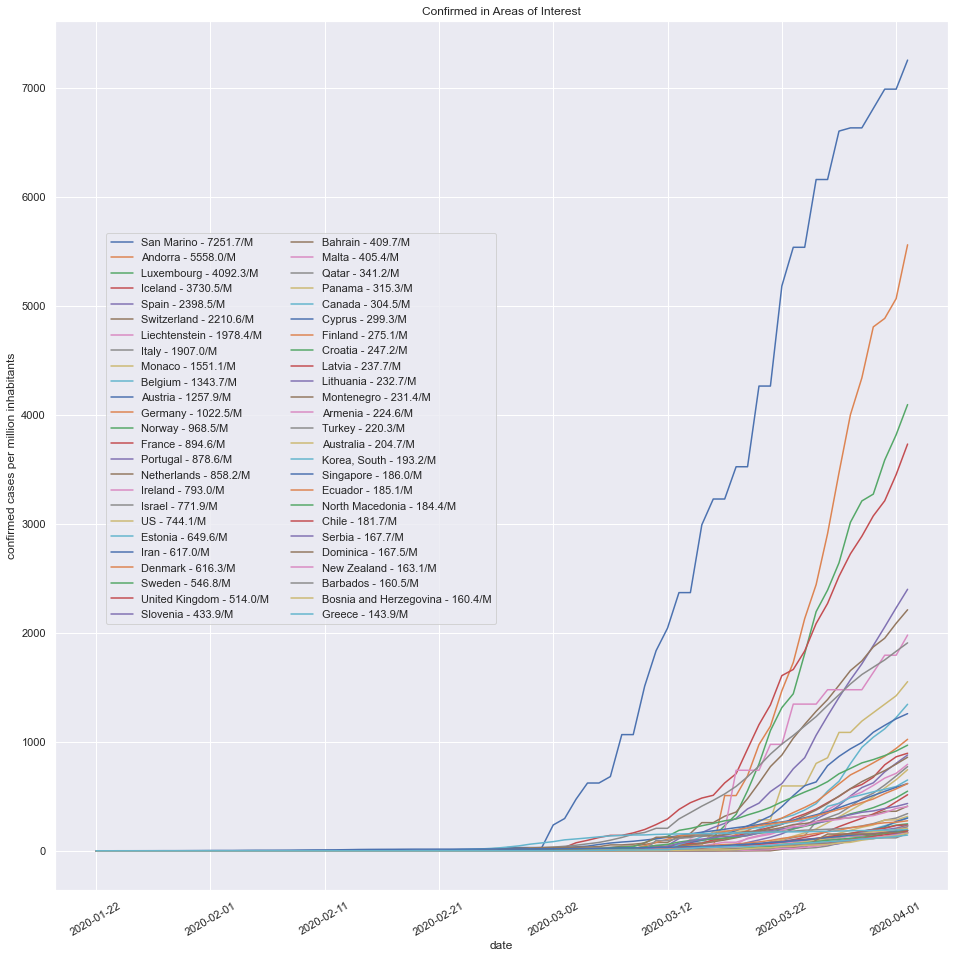

In [9]:
filename = "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
world = pd.read_csv(filename, skiprows=0)
world = world.drop(columns=['Lat', 'Long']).rename(columns={"Province/State": "region", "Country/Region": "country"})
world['region'] = world['region'].fillna("")
world = world.groupby(by=['country']).sum()
world['region'] = ""

world = pd.merge(world, pop,  how='inner', left_on=['country', 'region'], right_on=['country', 'region'])
world = world.drop(columns=['region'])
# rename columns
columns = dict([(d, str(dateparser.parse(d).date())) for d in world.columns if d not in ['population']])
world = world.rename(columns=columns)

world_pop = world.copy()

for d in world.columns:
    if d in ['country', 'population']:
        continue
    p = world['population']
    dd = str(dateparser.parse(d).date())
    world_pop[dd] = world[d].divide(p)*1000000.0
world = world.drop(columns=['population'])
world_pop = world_pop.drop(columns=['population'])
last_date = max(world_pop.columns)
world_pop = world_pop.sort_values(by=[last_date], ascending=False)
last = world_pop[last_date]

world_pop = world_pop.transpose()

countries = last[:50]
labels = list(map(lambda x: "%s - %.1f/M" % (x[0], x[1]), zip(countries.index, countries.values)))
ax = world_pop[countries.index].plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.5, 0.3), ncol=2)
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
pass


# Comparison of areas of interest - Percent of Population confirmed

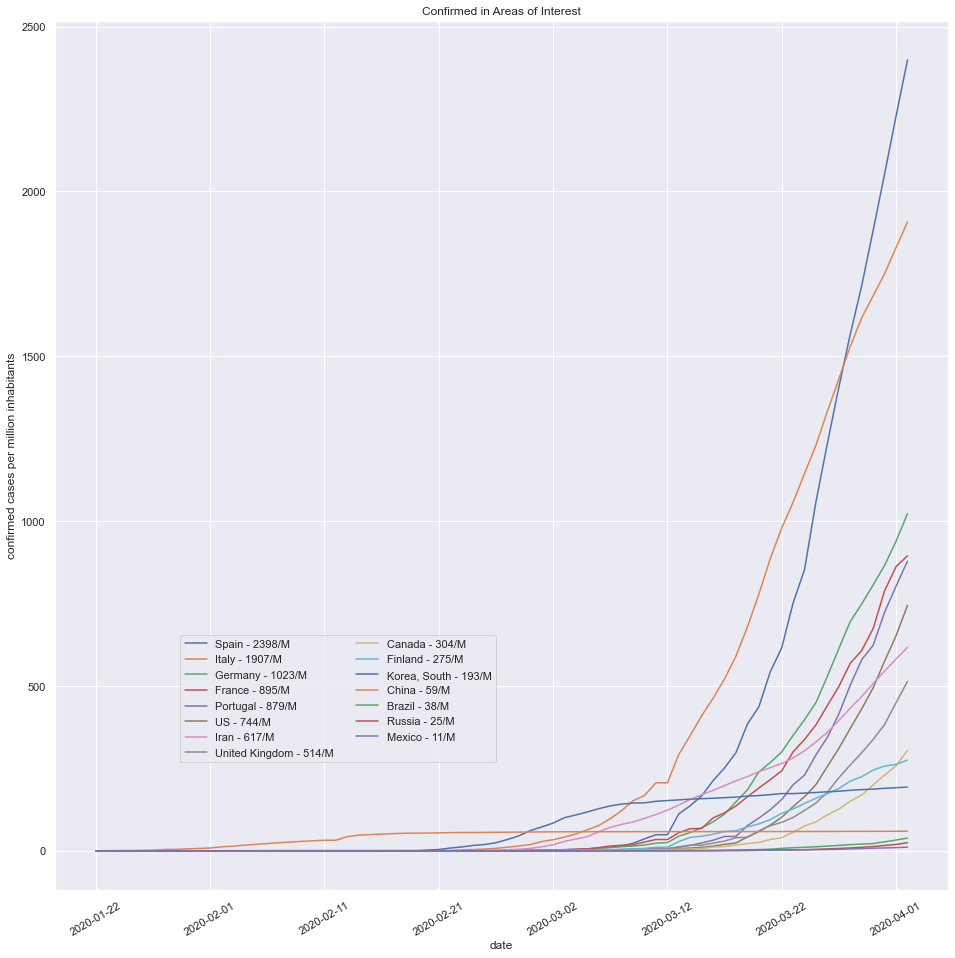

In [10]:
areas_of_interest = ['US', 'Canada', 'Iran', 'China', 'Korea, South', 'Italy', 'Spain',
                    'Germany', 'France', 'United Kingdom', 'Russia', 'Finland', 'Portugal',
                    'Brazil', 'Mexico']

areas = list(filter(lambda x: x in areas_of_interest, last.index))

countries = last[areas]
labels = list(map(lambda x: "%s - %.f/M" % (x[0], x[1]), zip(countries.index, countries.values)))
ax = world_pop[countries.index].plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.5, 0.3), ncol=2)
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
pass

In [11]:
world_pop[countries.index].tail(6)

country,Spain,Italy,Germany,France,Portugal,US,Iran,United Kingdom,Canada,Finland,"Korea, South",China,Brazil,Russia,Mexico
2020-03-28,1567.404191,1530.200840,695.724656,568.839644,502.832102,371.302237,432.859212,260.373932,150.463360,211.487754,183.556754,58.876451,18.637573,8.748734,5.681873
2020-03-29,1714.545637,1616.530299,748.782780,607.697788,579.861701,430.623544,468.323643,297.492859,169.460169,224.717065,185.590249,58.964767,20.318010,10.617530,6.719983
2020-03-30,1882.468806,1683.548569,806.543784,674.307485,623.239480,494.569395,507.272170,337.695003,199.628397,245.014090,187.100844,59.019336,21.860002,12.707813,7.869037
2020-03-31,2052.981665,1750.616481,865.908590,788.612829,723.903160,575.155044,545.291605,383.236377,230.093449,256.974837,189.521671,59.077495,27.292778,16.175467,8.669413
2020-04-01,2228.374269,1829.747682,939.032332,862.089505,802.488912,652.179825,581.819603,449.172104,257.968028,262.049093,191.477699,59.136372,32.634849,19.220913,9.628278
2020-04-02,2398.459079,1906.992443,1022.502409,894.633014,878.643174,744.123573,616.966186,513.964786,304.488622,275.097181,193.201327,59.187351,38.401803,24.557364,10.919973


# Select US States and Canadian Provinces
## Percentage of population confirmed

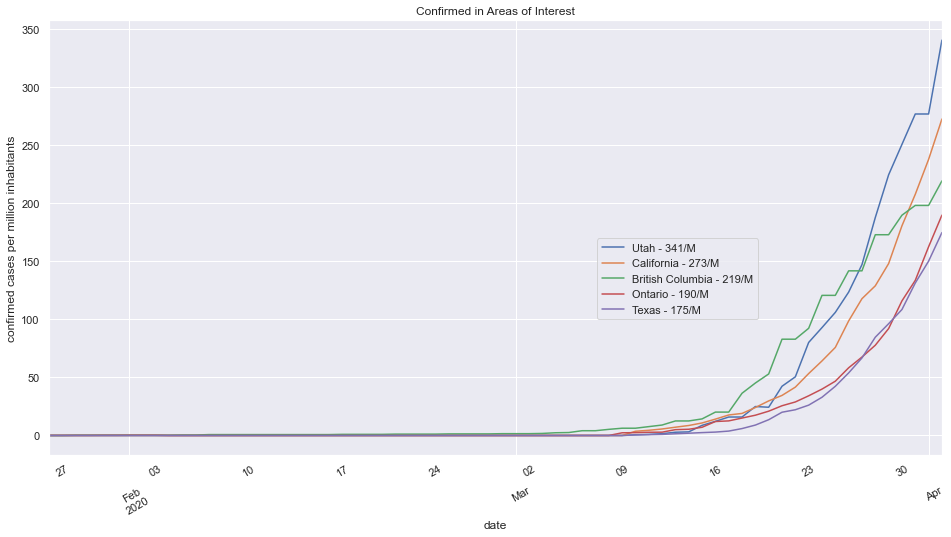

In [12]:
interest = [('US', 'Texas'), ('US', 'Utah'), ('US', 'California'), ('Canada', 'British Columbia'), ('Canada', 'Ontario')]

def f(x):
    if x[0:2] not in interest:
        return False
    
    return True

usa_areas = list(filter(f, usa.columns))
canada_areas = list(filter(f, canada.columns))

u = usa[['Texas', 'Utah', 'California']]
c = canada[['Ontario', 'British Columbia']]

of_interest = pd.DataFrame()
for column in c.columns:
    of_interest[column] = c[column]
for column in u.columns:
    of_interest[column] = u[column]
of_interest = of_interest.fillna(0)

last_date = max(of_interest.index)
last = of_interest.loc[last_date].sort_values(ascending=False).fillna(0)

labels = ["%s - %.f/M" % v for v in zip(last.index, last.values)]
ax = of_interest[last.index].plot(rot=30, figsize=(16,8), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.8, 0.3))
ax.set_xlabel("date")
ax.set_ylabel("confirmed cases per million inhabitants")
pass